# Preprocessing of Products for Food and Meat

In [2]:
# TODO: Add an explanation paragraph

## Environment Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import re
from requests import get
from bs4 import BeautifulSoup

## Data

In [6]:
df_products = pd.read_csv('dunnhumby/product.csv', sep = ',')
df_products.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [7]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_products), len(df_products.columns))) 

There are 92353 rows and 7 columns in the dataset.


In [8]:
print('Number of columns with missing values is {0}.'.format(len(df_products.columns.to_numpy()[df_products.isna().any()])))

Number of columns with missing values is 0.


In [9]:
print('Columns:')
print('--------')
for col in df_products.columns:
    print(col)

Columns:
--------
PRODUCT_ID
MANUFACTURER
DEPARTMENT
BRAND
COMMODITY_DESC
SUB_COMMODITY_DESC
CURR_SIZE_OF_PRODUCT


In [10]:
print('There are {0} unique products distributed in {1} different departments.'.format(len(df_products['PRODUCT_ID'].unique()), len(df_products['DEPARTMENT'].unique())))

There are 92353 unique products distributed in 44 different departments.


## Food Data

In [11]:
food_dep = ['GROCERY', 'PASTRY', 'MEAT-PCKGD','SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI',
       'MEAT', 'SEAFOOD', 'SALAD BAR', 'GRO BAKERY','FROZEN GROCERY', 'SPIRITS', 'RESTAURANT',
       'DAIRY DELI', 'CHEF SHOPPE', 'DELI/SNACK BAR', 'PORK']

In [12]:
df_food_products = df_products[df_products.DEPARTMENT.isin(food_dep)].copy()
print('There are {0} unique food products distributed in {1} different departments.'.format(len(df_food_products['PRODUCT_ID'].unique()), len(df_food_products['DEPARTMENT'].unique())))

There are 56031 unique food products distributed in 18 different departments.


Text(0.5, 1.0, 'Number of Food Products per Department')

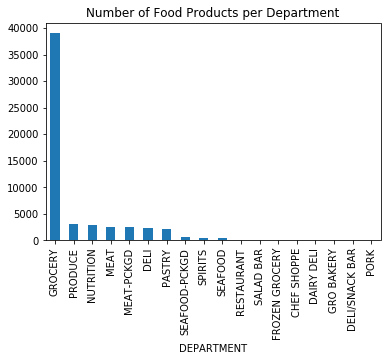

In [13]:
df_food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar()
plt.title('Number of Food Products per Department')

In [14]:
percent = int(len(df_food_products[df_food_products.DEPARTMENT == 'GROCERY']) * 100 / len(df_food_products))
print(f'The GROCERY department contains nearly {percent}% of the products in the food sector. It may be useful to have a deeper look in it for better information on the type of products it contains.')

The GROCERY department contains nearly 69% of the products in the food sector. It may be useful to have a deeper look in it for better information on the type of products it contains.


In [15]:
df_food_products[df_food_products.DEPARTMENT == 'GROCERY'].COMMODITY_DESC.unique()

array(['FRZN ICE', 'FRUIT - SHELF STABLE', 'COOKIES/CONES',
       'SPICES & EXTRACTS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'AIR CARE', 'CHEESE', 'SHORTENING/OIL',
       'COFFEE', 'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'FRZN FRUITS', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'BAKING MIXES',
       'FLUID MILK PRODUCTS', 'SOUP', 'BAKED SWEET GOODS',
       'DRY BN/VEG/POTATO/RICE', 'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA',
       'EGGS', 'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'CANNED JUICES',
       'BAG SNACKS', 'BEANS - CANNED GLASS & MW', 'CRACKERS/MISC BKD FD',
       'CONVENIENT BRKFST/WHLSM SNACKS', 'SOFT DRINKS', 'BUTTER',
       'FRZN MEAT/MEAT DINNERS', 'WATER - CARBONATED/FLVRD D

It is clearly seen that some of the COMMODITY_DESC correspond to housecleaning and non-food commodities. 
Therefore, they have to be removed in the next step.

In [16]:
non_food_groceries = ['AIR CARE', 'PAPER HOUSEWARES', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG', 'FACIAL TISS/DNR NAPKIN',\
                     'LAUNDRY DETERGENTS', 'LAUNDRY ADDITIVES', 'CAT FOOD', 'BATH TISSUES', 'DOG FOODS', 'BLEACH', 'PAPER TOWELS',\
                     'DISHWASH DETERGENTS', 'CAT LITTER', 'COUPON/MISC ITEMS', 'PET CARE SUPPLIES', 'BIRD SEED', 'BOTTLE DEPOSITS']
df_food_products = df_food_products[~df_food_products['COMMODITY_DESC'].isin(non_food_groceries)]
print('There are {0} unique food products distributed in {1} different departments.'.format(len(df_food_products['PRODUCT_ID'].unique()), len(df_food_products['DEPARTMENT'].unique())))

There are 51341 unique food products distributed in 18 different departments.


Text(0.5, 1.0, 'Number of Food Products per Department')

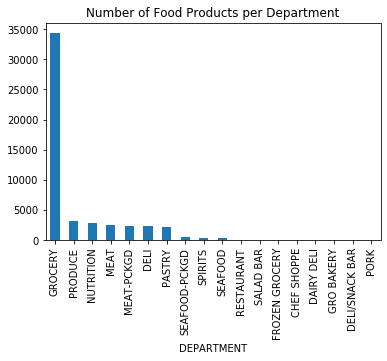

In [17]:
df_food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar()
plt.title('Number of Food Products per Department')

In [40]:
df_food_products.to_csv('data/food_products.csv')

## Meat Data

### Web scraping for meat-related words

To detect meat related products automatically, we use [listchallenges.com](https://www.listchallenges.com/types-of-meat) and [manythings.com](https://www.manythings.org/vocabulary/lists/c/words.php) to get the words related to meat. These words are then used to select all the products whose DEPARTMENT, COMMODITY_DESC or SUB_COMMODITY_DESC contain one of these words.

In [43]:
meat_words = []

# First Website
urls = ["https://www.listchallenges.com/types-of-meat", "https://www.listchallenges.com/types-of-meat/list/2"]
for url in urls:
    r = get(url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    meat_divs = soup.findAll("div", {"class": "item-name"})
    meat_words.extend([div.text.upper().strip() for div in meat_divs])
    
# Second Website   
base_url = "https://www.manythings.org/vocabulary/lists/c/words.php"
urls = [base_url + "?f=meat", base_url + "?f=fish"]
for url in urls:
    r = get(url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    meat_li = soup.findAll("li")
    meat_words.extend([li.text.upper().strip() for li in meat_li])

In [45]:
# add particular words that are not in both websites
meat_words.extend(["SALAMI", "HAM", "POULTRY", "SEAFOOD", "FISH","MEAT","MEATS"])
print('keywords:', meat_words)

keywords: ['ANCHOVY', 'BACON', 'BEEF', 'BUFFALO', 'CARIBOU', 'CATFISH', 'CHICKEN', 'CLAMS', 'COD', 'CORNISH GAME HEN', 'CRAB', 'DUCK', 'EEL', 'EMU', 'GOAT', 'GOOSE', 'GROUSE', 'HALIBUT', 'HAM', 'KANGAROO', 'LAMB', 'LOBSTER', 'MACKEREL', 'MAHI MAHI', 'OCTOPUS', 'OSTRICH', 'OYSTERS', 'PHEASANT', 'PORK', 'QUAIL', 'RABBIT', 'SALMON', 'SARDINES', 'SCALLOPS', 'SHARK', 'SHRIMP', 'SNAKE', 'SQUAB', 'SQUID', 'SWORDFISH', 'TILAPIA', 'TUNA', 'TURKEY', 'VEAL', 'VENISON', 'SALAMI', 'HAM', 'POULTRY', 'SEAFOOD', 'FISH', 'MEAT', 'MEATS', 'SALAMI', 'HAM', 'POULTRY', 'SEAFOOD', 'FISH', 'MEAT', 'MEATS']


In [48]:
meat_words_regex = [r'\b%s\b' % word for word in meat_words]
full_regex = re.compile('|'.join(meat_words_regex))
meat_products = df_products[df_products.DEPARTMENT.str.contains(full_regex, regex=True)|\
                          df_products.COMMODITY_DESC.str.contains(full_regex, regex=True) |\
                          df_products.SUB_COMMODITY_DESC.str.contains(full_regex, regex=True)]
print('There are {0} meat products distributed in {1} different departments.'.format(len(meat_products['PRODUCT_ID'].unique()), len(meat_products['DEPARTMENT'].unique())))

There are 9039 meat products distributed in 12 different departments.


In [54]:
print('Unique commodity description for selected products:')
print('---------------------------------------------------')
meat_products['COMMODITY_DESC'].unique()

Unique commodity description for selected products:
---------------------------------------------------


array(['DINNER SAUSAGE', 'SEAFOOD - FROZEN', 'SEAFOOD - SHELF STABLE',
       'FROZEN MEAT', 'FRZN MEAT/MEAT DINNERS',
       'BEANS - CANNED GLASS & MW', 'MEAT - SHELF STABLE', 'MEAT - MISC',
       'LUNCHMEAT', 'BREAKFAST SAUSAGE/SANDWICHES', 'BACON', 'HOT DOGS',
       'CHICKEN', 'HEAT/SERVE', 'DELI MEATS', 'BEEF', 'MISCELLANEOUS',
       'WAREHOUSE SNACKS', 'CHICKEN/POULTRY', 'TURKEY', 'SEAFOOD-FRESH',
       'SEAFOOD - MISC', 'MISC. DAIRY', 'FROZEN CHICKEN', 'SMOKED MEATS',
       'DINNER MXS:DRY', 'PORK', 'SALADS/DIPS', '(CORP USE ONLY)',
       'CONDIMENTS/SAUCES', 'LAMB', 'BAKING NEEDS', 'DRY SAUCES/GRAVY',
       'PARTY TRAYS', 'FROZEN', 'REFRIGERATED', 'VEAL', 'PASTA SAUCE',
       'FROZEN - BOXED(GROCERY)', 'FRZN SEAFOOD', 'SPICES & EXTRACTS',
       'PREPARED/PKGD FOODS', 'COUPON', 'PREPARED FOOD',
       'RW FRESH PROCESSED MEAT', 'EXOTIC GAME/FOWL', 'MEAT SUPPLIES',
       'DELI SUPPLIES', 'COUPON/MISC ITEMS', 'BAKING MIXES', 'BAG SNACKS',
       'NO COMMODITY DESCRIPTION

As for food products, some products are incorrectly placed in the meat category. They have to be removed by hand as before.

In [66]:
meat_drops_sub = [ 'FROZEN MEAT (VEGETARIAN)', 'VEGETARIAN MEATS', 'FRZN MEAT ALTERNATIVES', 'SAUERKRAUT', 'PICKLES',\
                  'SALADS', 'CHEESE', 'PICKLE ITEMS', 'SAL:OLIVES/PICKLES-BULK', 'POTATOES PROCESSED',\
                  'NON-MEATS - OTHER', 'MISC SALES TRANS', 'NON-MEATS - OTHER']

meat_products = meat_products[~meat_products['SUB_COMMODITY_DESC'].isin(meat_drops_sub)]
meat_products = meat_products[~(meat_products['DEPARTMENT'] == 'MISC SALES TRAN')]
print('There are {0} meat products distributed in {1} different departments.'.format(len(meat_products['PRODUCT_ID'].unique()), len(meat_products['DEPARTMENT'].unique())))

There are 8785 meat products distributed in 10 different departments.


Text(0.5, 1.0, 'Number of Meat Products per Department')

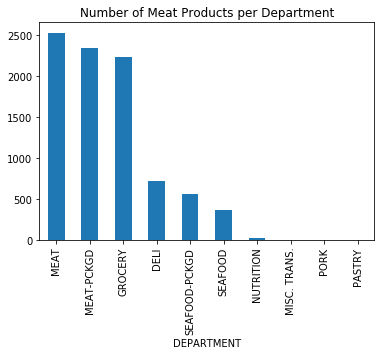

In [67]:
meat_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar()
plt.title('Number of Meat Products per Department')

In [72]:
percent = int(len(meat_products) * 100 / len(df_food_products))
print(f"We can see that {percent}% of the food products are meat related products.")

We can see that 17% of the food products are meat related products.


In [74]:
meat_products.to_csv('data/meat_products.csv')

## Vegetables Data

In [18]:
veggies = [
    "asparagus",
    "beans",
    "beet",
    "broccoli",
    "Brussels sprouts",
    "cabbage",
    "carrot",
    "carrots",
    "cauliflower",
    "celery",
    "Chinese cabbage",
    "corn",
    "cucumber",
    "cucumbers",
    "eggplant",
    "eggplants",
    "green pepper",
    "Japanese radish",
    "kale",
    "lettuce",
    "salad",
    "okra",
    "onion",
    "onions",
    "peas",
    "pumpkins",
    "radish",
    "spinach",
    "sweet potato",
    "tomatoes",
    "tomato",
    "turnips",
    "vegetables"
]
veggies = [v.upper() for v in veggies]

In [20]:
veggie_words_regex = [r'\b%s\b' % word for word in veggies]
full_regex = re.compile('|'.join(veggie_words_regex))

veggie_products = df_products[df_food_products.COMMODITY_DESC.str.contains(full_regex, regex=True) |\
                           df_products.SUB_COMMODITY_DESC.str.contains(full_regex, regex=True)]

In [21]:
veggie_products.COMMODITY_DESC.unique()

array(['SHORTENING/OIL', 'VEGETABLES - SHELF STABLE', 'HISPANIC',
       'FRZN VEGETABLE/VEG DSH', 'CANNED JUICES',
       'BEANS - CANNED GLASS & MW', 'DRY BN/VEG/POTATO/RICE',
       'ORGANICS FRUIT & VEGETABLES', 'CONDIMENTS/SAUCES',
       'SALD DRSNG/SNDWCH SPRD', 'FROZEN MEAT', 'FRUIT - SHELF STABLE',
       'SALAD MIX', 'CARROTS', 'VEGETABLES - ALL OTHERS', 'CORN',
       'BAG SNACKS', 'BAKING MIXES', 'BROCCOLI/CAULIFLOWER', 'ONIONS',
       'CRACKERS/MISC BKD FD', 'SPICES & EXTRACTS', 'VEGETABLES SALAD',
       'VALUE ADDED VEGETABLES', 'TOMATOES', 'SALAD BAR', 'FROZEN',
       'PREPARED/PKGD FOODS', 'HERBS', 'SALADS/DIPS', 'BAKING NEEDS',
       'SOUP', 'SEASONAL', 'UNKNOWN', 'MEAT - SHELF STABLE',
       'PROD SUPPLIES', 'DELI SPECIALTIES (RETAIL PK)', 'FROZEN PIZZA'],
      dtype=object)

In [22]:
drops_vegg = ['SHORTENING/OIL','CONDIMENTS/SAUCES', 'SALD DRSNG/SNDWCH SPRD', 'FROZEN MEAT','BAG SNACKS', 'BAKING MIXES',\
             'CRACKERS/MISC BKD FD', 'SPICES & EXTRACTS','BAKING NEEDS','MEAT - SHELF STABLE','DELI SPECIALTIES (RETAIL PK)', 'FROZEN PIZZA']
veggie_products = veggie_products[veggie_products['COMMODITY_DESC'].isin(drops_vegg) == 0]
print('There are {0} veggetables products distributed in {1} different departments.'.format(len(veggie_products['PRODUCT_ID'].unique()), len(veggie_products['DEPARTMENT'].unique())))

There are 3209 veggetables products distributed in 7 different departments.


In [25]:
percent = int(len(veggie_products) * 100 / len(df_food_products))
print(f"We can see that {percent}% of the food products are vegetables products.")

We can see that 6% of the food products are vegetables products.


In [26]:
veggie_products.to_csv('data/vegetables_products.csv')